# Environmental Effects on Beam Position Drift

The electron beam in the Australian Synchrotron is as narrow as a human hair (322.9 micrometers). It orbits inside a vacuum chamber with a circumference of 215 meters and the narrow vacuum tube is only 6.4mm wide in some places. For the protection of sensitive electronics, the beam is given a tolerance of 1mm divergence from the centre of it's orbit. The accelerator is made up of materials that are sensitive to thermal expansion, and so small drifts in temperature can cause either the appearance of or real shifts in the beam position.

The purpose of this analysis is to determine whether the primary source of thermal drift is inside the accelerator enclosure, effecting the cables and electronic pickups at the electron beam, or outside in the tech hall where the telemetry is sent for signal processing (by Libera Brilliance+ instruments) and storage via RF cables. Particularly, the question that I'm looking to answer is whether we can stabilise the electron beam further by adding environmental controls the server racks which house the Libera instrumentation.

## <font color='blue'> Data Import & Cleaning</font>
Steps in this section:
- Read in the data
- Create dataframes for each
- Set column names
- Set data to appropriate formats (i.e. datetime) 
- Set datetime as index

## Load data

Environment data was provided in matlab files, loaded into numpy then joined into a dataframe

In [39]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

raw_data = loadmat('SR11_dataset.mat') # <-------------------------------------- Enter dataset name
sector = "SR11" # <------------------------------------------------------------- Enter dictionary key

# temperature at Libera rack
temp_rack_t = raw_data[sector][0][0][0]     # temp_rack_t:   [59100×1 double]
temp_rack = raw_data[sector][0][0][1]       # temp_rack:     [59100×1 double]
temp_rack = pd.DataFrame(np.concatenate((temp_rack_t,temp_rack), axis = 1))
temp_rack = temp_rack.rename(columns={0: "temp_rack_t", 1: "temp_rack"})
temp_rack['temp_rack_t'] = temp_rack['temp_rack_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
temp_rack.set_index('temp_rack_t', inplace=True)

# temperature in accelerator enclosure
temp_tunnel_t = raw_data[sector][0][0][2]   # temp_tunnel_t: [2072×1 double]
temp_tunnel = raw_data[sector][0][0][3]     # temp_tunnel:   [2072×1 double]
temp_tunnel = pd.DataFrame(np.concatenate((temp_tunnel_t,temp_tunnel), axis = 1))
temp_tunnel = temp_tunnel.rename(columns={0: "temp_tunnel_t", 1: "temp_tunnel"})
temp_tunnel['temp_tunnel_t'] = temp_tunnel['temp_tunnel_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
temp_tunnel.set_index('temp_tunnel_t', inplace=True)

# humidity on tech floor
humidity_t = raw_data[sector][0][0][4]      # humidity_t:    [42042×1 double]
humidity = raw_data[sector][0][0][5]        # humidity:      [42042×1 double]  
humidity = pd.DataFrame(np.concatenate((humidity_t,humidity), axis = 1))
humidity = humidity.rename(columns={0: "humidity_t", 1: "humidity"})
humidity['humidity_t'] = humidity['humidity_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
humidity.set_index('humidity_t', inplace=True)

The circumference of the storage ring (where the electrons are held in a closed orbit with revolution frequency of 1.4 MHz) is divided into 14 sectors, each sector has seven vertical and horizontal position monitors. The orbit data is saved at a substantially higher rate than the environmental data (freq = 1.4MHz / period = 0.714μs), the beam position data provided has already been substantially down sampled using unknown methods.

Beam position monitoring data files loaded from .mat file into numpy then joined into a dataframe:

In [40]:
# horizontal position monitoring over seven bpms in the specified sector

bpmx_t = raw_data[sector][0][0][8]          # bpmx_t:        [154327×1 double]
bpmx = raw_data[sector][0][0][9]            # bpmx:          [154327×7 double]
bpmx = pd.concat([pd.DataFrame(data = bpmx_t, columns = ['bpm_t']),pd.DataFrame(bpmx)], axis = 1)
bpmx = bpmx.rename(columns={0: "bpm1", 
                            1: "bpm2", 
                            2: "bpm3", 
                            3: "bpm4", 
                            4: "bpm5", 
                            5: "bpm6", 
                            6: "bpm7",})
bpmx['bpm_t'] = bpmx['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmx.set_index('bpm_t', inplace=True)
bpmx.head()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-15 06:00:00.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2020-09-15 06:00:03.359125,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:06.718240,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:10.077364,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:13.436489,0.0,0.0,-0.013,0.0,0.0,0.0,0.0


In [41]:
# vertical position monitoring over seven bpms in the specified sector

bpmy_t = raw_data[sector][0][0][6]          # bpmy_t:        [382179×1 double]
bpmy = raw_data[sector][0][0][7]            # bpmy:          [382179×7 double]
bpmy = pd.concat([pd.DataFrame(data = bpmy_t, columns = ['bpm_t']),pd.DataFrame(bpmy)], axis = 1)
bpmy = bpmy.rename(columns={0: "bpm1", 
                            1: "bpm2", 
                            2: "bpm3", 
                            3: "bpm4", 
                            4: "bpm5", 
                            5: "bpm6", 
                            6: "bpm7",})
bpmy['bpm_t'] = bpmy['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmy['bpm_t'] = pd.to_datetime(bpmy['bpm_t'])
bpmy.set_index('bpm_t', inplace=True)
bpmy.tail()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-21 05:59:54.574260,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:55.930700,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:57.287130,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:58.643560,1.049,0.108,NaN,NaN,NaN,NaN,NaN
2020-09-21 06:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot initial datasets and make sure there are no problematic anomalies

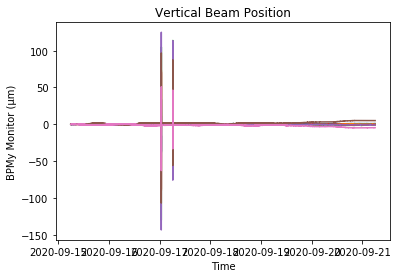

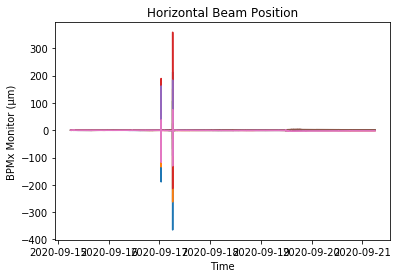

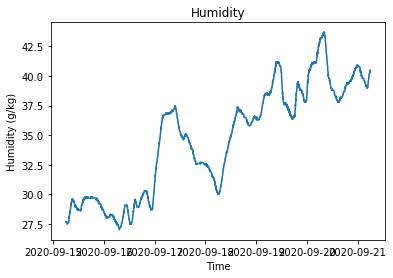

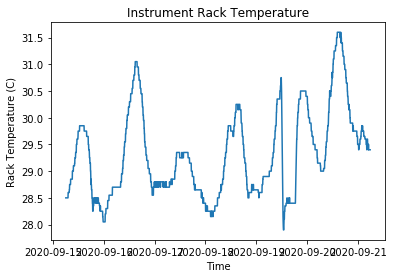

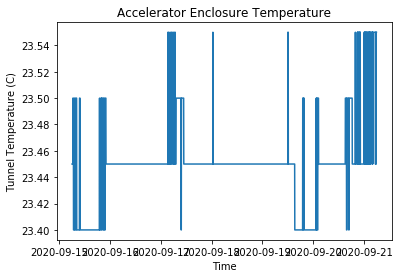

In [42]:
import matplotlib.pyplot as plt

plt.plot(bpmy)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.show()

plt.plot(bpmx)
plt.title('Horizontal Beam Position')
plt.ylabel('BPMx Monitor (μm)')
plt.xlabel('Time')
plt.show()

plt.plot(humidity)
plt.title('Humidity')
plt.ylabel('Humidity (g/kg)')
plt.xlabel('Time')
plt.show()

plt.plot(temp_rack)
plt.title('Instrument Rack Temperature')
plt.ylabel('Rack Temperature (C)')
plt.xlabel('Time')
plt.show()

plt.plot(temp_tunnel)
plt.title('Accelerator Enclosure Temperature')
plt.ylabel('Tunnel Temperature (C)')
plt.xlabel('Time')
plt.show()

The low resolution of the Tunnel Temperature data may make it challenging to gain any helpful insight from this variable.

The beam position plots show large perturbations in the vertical and horizontal beam position, perturbations of this size are typically caused during machine studies when physicists need to measure the electron beam response to the magnets that control the beam positioning, this is referred to as a LOCO (Linear Optical from Closed Orbits) measurement. This data needs to be excluded, as it does not result from the environmental impacts that we're trying to measure.

![Electron Orbit Studies](LOCO-interference.png)

If the perturbations are minimal, it's possible we could use outlier methods to remove the unwanted data:

C:\Users\chalmerm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


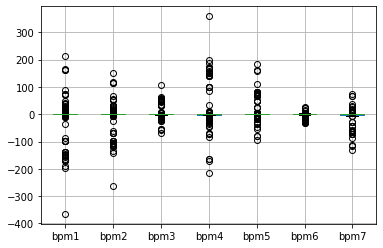

In [43]:
bpmx.boxplot()

C:\Users\chalmerm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


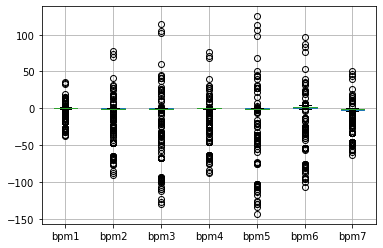

In [44]:
bpmy.boxplot()

Unfortunately, it appears the perturbations occur in more than just a couple of data points, instead we'll crop the data down to exclude everything before the period of machine studies.

## <font color='blue'>Trim the LOCO data</font>
In this section:
- Trip LOCO data 
- Handle Nan's
- Match start and end times of beam and environment data

In [45]:
# bpmy has LOCO data between 100000 - 130000

#bpmy_start = 130000  # < -----------------------------------------------Set sub-potion of data by start & end index
#bpmy_end = round((len(bpmy)-130000)*2/3) + bpmy_start

bpmy_start = 0
bpmy_end = 100000

# bpmx has bad data between 50000 - 51800
#bpmx_start = 51800 # < -----------------------------------------------Set sub-potion of data by start & end index
#bpmx_end = round((len(bpmx)-51800)*2/3) + bpmx_start

bpmx_start = 0 
bpmx_end = 50000


# Drop Nans and trim loco data
bpmy_trim = bpmy.iloc[bpmy_start:bpmy_end].dropna()
bpmx_trim = bpmx.iloc[bpmx_start:bpmx_end].dropna()
temp_rack_trim = temp_rack.dropna()
temp_tunnel_trim = temp_tunnel.dropna()
humidity_trim = humidity.dropna()

bpmy_trim.iloc[1:6,1:3]


,bpm2,bpm3
bpm_t,,
2020-09-15 06:00:01.356440,0.000,0.000
2020-09-15 06:00:02.712870,0.000,0.045
2020-09-15 06:00:04.069300,0.000,0.045
2020-09-15 06:00:05.425740,0.000,0.045
2020-09-15 06:00:06.782180,-0.004,0.045


Truncate datasets to match start and end times

In [46]:
# Truncate each dataset on upper and lower bounds

upper_bound = np.array([bpmy_trim.index.values.max(),
                        bpmx_trim.index.values.max(),
                        temp_rack_trim.index.values.max(),
                        temp_tunnel_trim.index.values.max(),
                        humidity_trim.index.values.max()
                        ]).min()

lower_bound = np.array([bpmy_trim.index.values.min(),
                        bpmx_trim.index.values.min(),
                        temp_rack_trim.index.values.min(),
                        temp_tunnel_trim.index.values.min(),
                        humidity_trim.index.values.min()
                        ]).max()

bpmy_trim = bpmy_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
bpmx_trim = bpmx_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
temp_rack_trim = temp_rack_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
temp_tunnel_trim = temp_tunnel_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
humidity_trim = humidity_trim.truncate(before=lower_bound, after=upper_bound, axis =0)

## <font color='blue'>Downsample High Resolution Beam Data</font>
In this section:
- The beam data and environment data don't cover the same time periods, this is matched up here.
- The data is also re-sampled so that the timing intervals of both datasets match

In [47]:
bpmx_resample = bpmx_trim.resample('5T').mean()
bpmy_resample = bpmy_trim.resample('5T').mean()
temp_tunnel_resample = temp_tunnel_trim.resample('5T').mean()
humidity_resample = humidity_trim.resample('5T').mean()
temp_rack_resample = temp_rack_trim.resample('5T').mean()

Plot clean dataset on same axis for final check

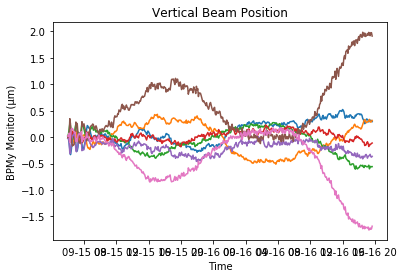

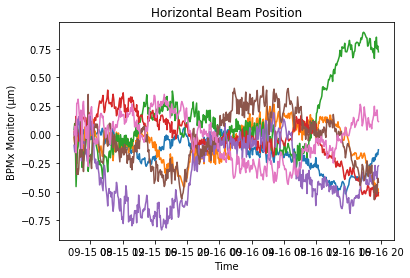

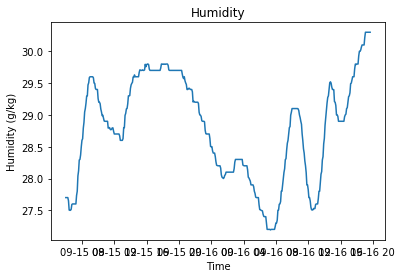

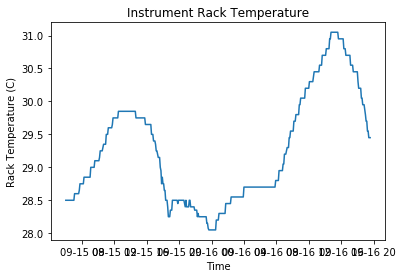

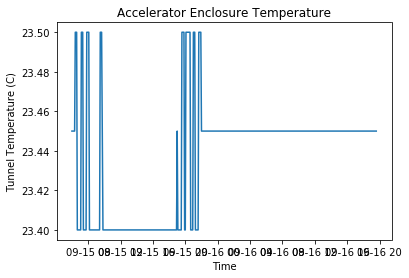

In [48]:
plt.plot(bpmy_resample)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.show()

plt.plot(bpmx_resample)
plt.title('Horizontal Beam Position')
plt.ylabel('BPMx Monitor (μm)')
plt.xlabel('Time')
plt.show()

plt.plot(humidity_resample)
plt.title('Humidity')
plt.ylabel('Humidity (g/kg)')
plt.xlabel('Time')
plt.show()

plt.plot(temp_rack_resample)
plt.title('Instrument Rack Temperature')
plt.ylabel('Rack Temperature (C)')
plt.xlabel('Time')
plt.show()

plt.plot(temp_tunnel_resample)
plt.title('Accelerator Enclosure Temperature')
plt.ylabel('Tunnel Temperature (C)')
plt.xlabel('Time')
plt.show()

## <font color='blue'> Visualise Synchrony </font>
Now that all our data is synchronised in a tabular format, it ca be overlaid in a single plot.

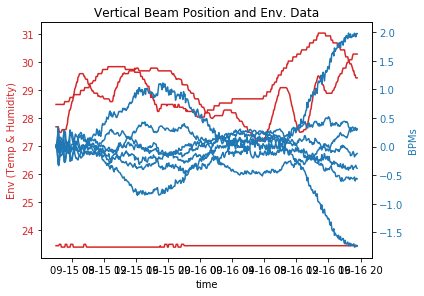

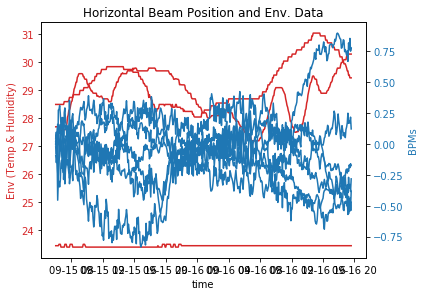

In [49]:
from matplotlib import cm

# One plot to overlay zoomed component, for time correlation estimate
all_y = pd.concat([bpmy_resample, temp_rack_resample, temp_tunnel_resample, humidity_resample], axis=1).dropna()
all_x = pd.concat([bpmx_resample, temp_rack_resample, temp_tunnel_resample, humidity_resample], axis=1).dropna()


# yplot
#############################

data1 = all_y.iloc[:, 7:10]
data2 = all_y.iloc[:, 0:7]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BPMs', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vertical Beam Position and Env. Data')
plt.show()

# xplot
##################################

data3 = all_x.iloc[:, 7:10]
data4 = all_x.iloc[:, 0:7]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color=color)
ax1.plot(data3, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BPMs', color=color)  # we already handled the x-label with ax1
ax2.plot(data4, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Horizontal Beam Position and Env. Data')
plt.show()

It's a bit difficult to see with all the Beam Position Monitors (BPMs) in a single colour, but it appears as though there will be a high correlation between one of out env parameters and the vertical beam positions, some will negatively correlate while others will positively correlate.

Below we filter some variables to show that relationship symmetry more clearly.

Positive correlation with rack temperature:

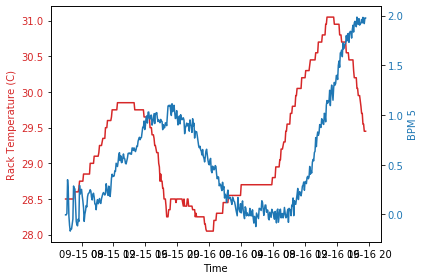

In [50]:
# Create some mock data
#t = np.arange(0.01, 10.0, 0.01)
data1 = all_y.iloc[:, 7]
data2 = all_y.iloc[:, 5]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Rack Temperature (C)', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BPM 5', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Interestingly, there appears to be a time lag, although the positive correlation symmetry is very clear.

A second example below:

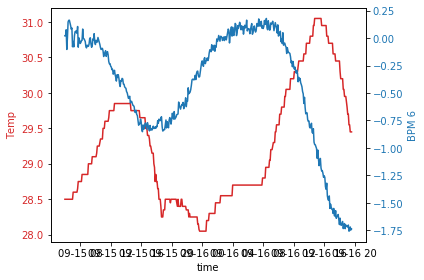

In [51]:
# Create some mock data
#t = np.arange(0.01, 10.0, 0.01)
data1 = all_y.iloc[:, 7:8]
data2 = all_y.iloc[:, 6:7]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Temp', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BPM 6', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In this instance we see symmetry which we expect to show a strong negative correlation.

Record the correlation coefficient (R) for initial datasets:

In [52]:
all_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,-0.849556,0.159646,0.622692,-0.304426,-0.595378,-0.227389,0.208214
temp_tunnel,-0.170410,0.132310,0.113994,-0.468094,0.484465,0.247078,-0.377628
humidity,-0.042746,-0.677070,0.411740,-0.052092,-0.645185,-0.703049,0.639257


In [53]:
all_y.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]


,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,0.641033,0.013379,-0.545885,-0.041121,0.104830,0.457443,-0.531827
temp_tunnel,0.215789,-0.285633,0.140665,0.253268,-0.144130,0.006059,0.018134
humidity,-0.153559,0.735598,-0.729412,-0.644870,-0.467447,0.692394,-0.687949


There are clearly elements of correlation between the beam position on each BPM and each env factor. Some BPMs appear to be more impacted by humidity than temperature, which is not entirely unexpected.

Below we scatter plot each BPM againts each environmental monitor.

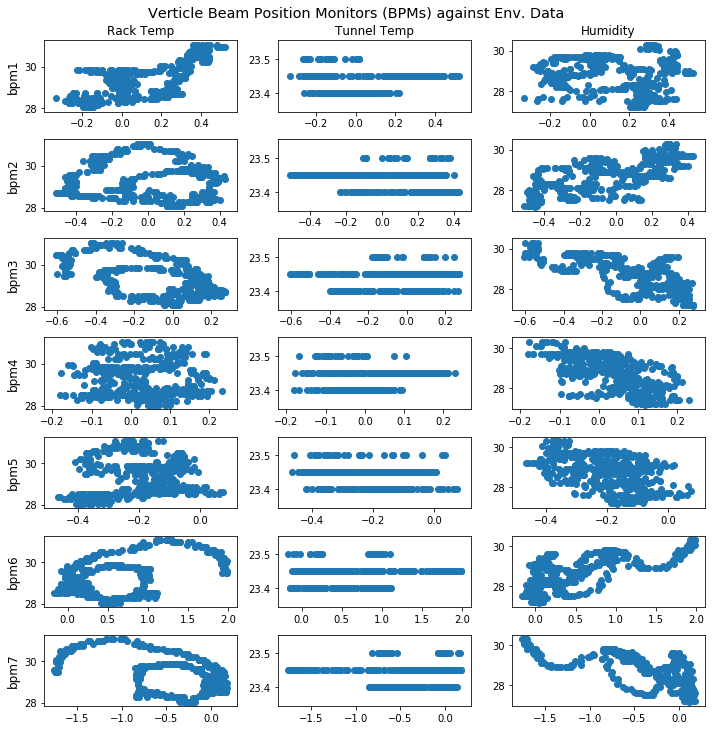

In [68]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_y[rows[i]],all_y['temp_rack'])
    axes[i][1].scatter(all_y[rows[i]],all_y['temp_tunnel'])
    axes[i][2].scatter(all_y[rows[i]],all_y['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Verticle Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

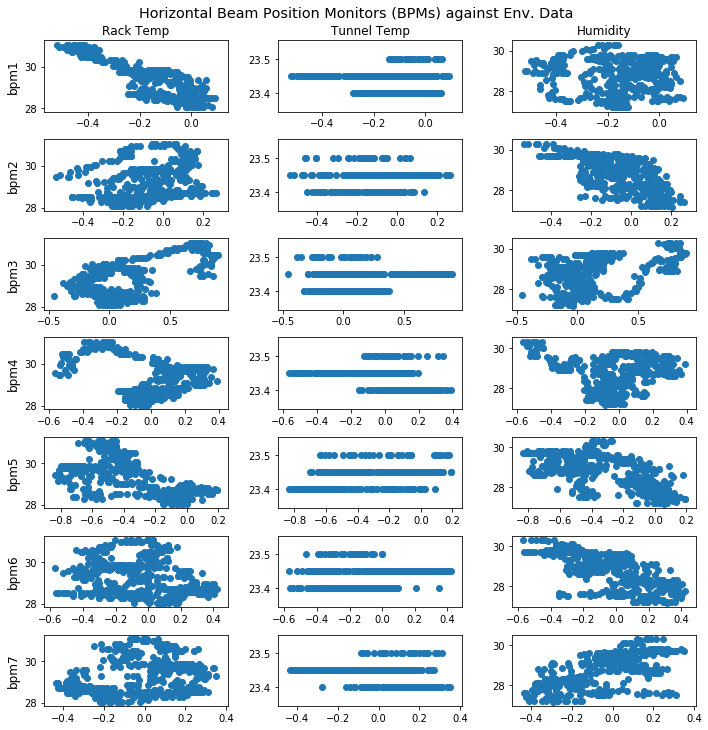

In [69]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_x[rows[i]],all_x['temp_rack'])
    axes[i][1].scatter(all_x[rows[i]],all_x['temp_tunnel'])
    axes[i][2].scatter(all_x[rows[i]],all_x['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Horizontal Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

## <font color='blue'> Time Lag Analysis </font>

We noticed there was a time lag between cause (environment change) and effect (beam position drift), we need to know how long this lag is and add an offset to the data so that we can obtain better correlation estimates.

![time Lag](time-lag.png)

It's unclear why there is a time lag, it could be related to poor air flow around the temperture monitoring, or any number of other reasons. This will be a consideration for future improvements if this work continuous.

In [105]:
data1 = all_y.iloc[:, 7]
data2 = all_y.iloc[:, 5]

data1[data1 == max(data1)].size

#data2[data2 == max(data2)]

#data2[[len(data2)-1]]
#plt.plot(data2)

11

The lag between cause (environment change) and effect (beam position drift) is estimated to be roughly 2-3 hours.



In [23]:
cor_lag_y = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_y)-1):
    data_bpms = all_y.iloc[0:len(all_y)-i,:]
    data_env = all_y.iloc[0+i:len(all_y),:]
    data = data_bpms.append(data_env)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_y = np.vstack((cor_lag_y, cor.values.flatten()))

cor_lag_x = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_x)-1):
    data_bpms = all_x.iloc[0:len(all_x)-i,:]
    data_env = all_x.iloc[0+i:len(all_x),:]
    data = data_bpms.append(data_env)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_x = np.vstack((cor_lag_x, cor.values.flatten()))

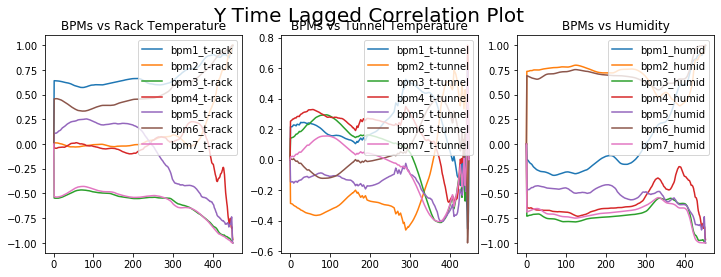

In [24]:
# Y TLCC correlation plots

cor_lag_y = pd.DataFrame(cor_lag_y)
cor_lag_y.columns = ['bpm1_t-rack', 
              'bpm2_t-rack',
              'bpm3_t-rack',
              'bpm4_t-rack',
              'bpm5_t-rack',
              'bpm6_t-rack',
              'bpm7_t-rack',
             'bpm1_t-tunnel', 
              'bpm2_t-tunnel',
              'bpm3_t-tunnel',
              'bpm4_t-tunnel',
              'bpm5_t-tunnel',
              'bpm6_t-tunnel',
              'bpm7_t-tunnel',
             'bpm1_humid', 
              'bpm2_humid',
              'bpm3_humid',
              'bpm4_humid',
              'bpm5_humid',
              'bpm6_humid',
              'bpm7_humid']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_y.iloc[:,0:7])
axes[0].legend(list(cor_lag_y.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_y.iloc[:,7:14])
axes[1].legend(list(cor_lag_y.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_y.iloc[:,14:21])
axes[2].legend(list(cor_lag_y.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('Y Time Lagged Correlation Plot', fontsize=20)

fig.set_figwidth(12)

plt.show()

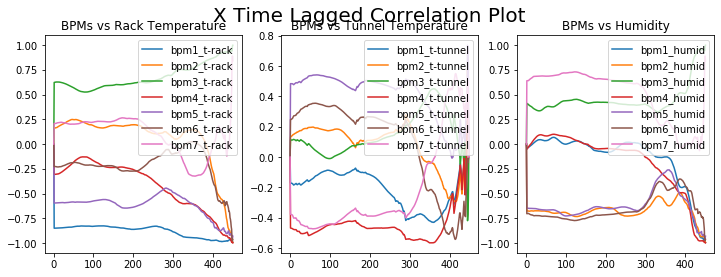

In [25]:
# X TLCC correlation plots

cor_lag_x = pd.DataFrame(cor_lag_x)
cor_lag_x.columns = ['bpm1_t-rack', 
              'bpm2_t-rack',
              'bpm3_t-rack',
              'bpm4_t-rack',
              'bpm5_t-rack',
              'bpm6_t-rack',
              'bpm7_t-rack',
             'bpm1_t-tunnel', 
              'bpm2_t-tunnel',
              'bpm3_t-tunnel',
              'bpm4_t-tunnel',
              'bpm5_t-tunnel',
              'bpm6_t-tunnel',
              'bpm7_t-tunnel',
             'bpm1_humid', 
              'bpm2_humid',
              'bpm3_humid',
              'bpm4_humid',
              'bpm5_humid',
              'bpm6_humid',
              'bpm7_humid']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_x.iloc[:,0:7])
axes[0].legend(list(cor_lag_x.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_x.iloc[:,7:14])
axes[1].legend(list(cor_lag_x.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_x.iloc[:,14:21])
axes[2].legend(list(cor_lag_x.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('X Time Lagged Correlation Plot', fontsize=20)

fig.set_figwidth(12)

plt.show()

Euclidean Time Matching

In [44]:
#from sklearn.metrics.pairwise import euclidean_distances
#Y = [[0, 1, 3, 10, 6, 3], [1, 1, 8, 3, 6, 0]]

#X = [[1, 3, 10, 1, 3], [1, 1, 8, 3, 1]]
# distance between rows of X
#euclidean_distances(X, X)
#array([[0., 1.],
#       [1., 0.]])
# get distance to origin
#euclidean_distances(X, [[0, 0]])
#array([[1.        ],
#       [1.41421356]])

#a = np.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0], dtype=float)
#b = np.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0], dtype=float)
#np.argmax(signal.correlate(a, b))

Dynamic Time Warp Matching

Signal correlation library (via FFT)

In [45]:
#import numpy as np
#from scipy import signal

#all_x = all_x.dropna()

#s0 = np.gradient(np.gradient(all_y['bpm7']))
#s1 = np.gradient(np.gradient(all_y['temp_rack']))
#corr = signal.correlate(s0, s1)

#plt.plot(corr)
#plt.show()


Try PCA reduction on enviro factors?

In [46]:
#import numpy as np
#from sklearn.decomposition import PCA
#X = np.array(all_y.iloc[0:7,0:1131].T.dropna().T)
#pca = PCA()
#pca.fit(X)

#print(pca.explained_variance_ratio_)

#print(pca.singular_values_)

## Quantify delay and apply
The best synchronisation method found yet is time lagged cross correlation

In [26]:
# delay is simply quantified by the index of the data

delay_track_y = cor_lag_y.iloc[0:200,0:7].abs().idxmax()
delay_track_y = delay_track_y.reset_index()[0]

delay_ttunnel_y = cor_lag_y.iloc[0:200,7:14].abs().idxmax()
delay_ttunnel_y = delay_ttunnel_y.reset_index()[0]

delay_humid_y = cor_lag_y.iloc[0:200,14:21].abs().idxmax()
delay_humid_y = delay_humid_y.reset_index()[0]

delay_track_x = cor_lag_x.iloc[0:200,0:7].abs().idxmax()
delay_track_x = delay_track_x.reset_index()[0]

delay_ttunnel_x = cor_lag_x.iloc[0:200,7:14].abs().idxmax()
delay_ttunnel_x = delay_ttunnel_x.reset_index()[0]

delay_humid_x = cor_lag_x.iloc[0:200,14:21].abs().idxmax()
delay_humid_x = delay_humid_x.reset_index()[0]

delay_y = pd.DataFrame({
    'temp_rack_x': delay_track_x,
    'temp_rack_y': delay_track_y,
    'temp_tunnel_x': delay_ttunnel_x,
    'temp_tunnel_y': delay_ttunnel_y,
    'humidity_x': delay_humid_x,
    'humidity_y': delay_humid_y
})
delay_y = delay_y.T
delay_y.columns = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
delay_y.T

,temp_rack_x,temp_rack_y,temp_tunnel_x,temp_tunnel_y,humidity_x,humidity_y
bpm1,199,199,27,27,199,70
bpm2,47,58,56,65,126,124
bpm3,12,199,9,91,125,122
bpm4,4,190,47,56,69,129
bpm5,182,82,66,189,99,153
bpm6,195,6,62,81,121,123
bpm7,172,199,56,93,124,122


## <font color='red'>Manually set delay here</font>
We have assumed that the same delay should be applied to every bpm for each env variable

In [27]:
# Manually apply delay, x and y seem to require the same delays
d_track_x = 47  # < ------------------------------------------------------Set delay manually based on above results
d_ttunnel_x = 50
d_humid_x = 120

d_track_y = 58
d_ttunnel_y = 27
d_humid_y = 199
max_d = np.array([d_track_x, d_track_y ,d_ttunnel_x, d_ttunnel_y, d_humid_x, d_humid_y]).max()

# synchronise X dataset
synch_x = all_x
synch_x.temp_rack = all_x.temp_rack.shift(d_track_x)
synch_x.temp_tunnel = all_x.temp_tunnel.shift(d_ttunnel_x)
synch_x.humidity = all_x.humidity.shift(d_humid_x)

synch_x = synch_x.dropna()

# synchronise Y dataset
synch_y = all_y
synch_y.temp_rack = all_y.temp_rack.shift(d_track_y)
synch_y.temp_tunnel = all_y.temp_tunnel.shift(d_ttunnel_y)
synch_y.humidity = all_y.humidity.shift(d_humid_y)

synch_y = synch_y.dropna()

synch_y

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7,temp_rack,temp_tunnel,humidity
bpm_t,,,,,,,,,,
2020-09-15 22:35:00,-0.209869,0.270176,-0.100140,0.053118,-0.398511,0.736869,-0.429710,28.95,23.50,27.700000
2020-09-15 22:40:00,-0.252063,0.263742,-0.038005,0.013054,-0.405471,0.692403,-0.381009,28.75,23.50,27.700000
2020-09-15 22:45:00,-0.218330,0.230995,-0.038579,0.015511,-0.374380,0.671122,-0.373706,28.85,23.50,27.700000
2020-09-15 22:50:00,-0.196779,0.229365,-0.056423,0.046437,-0.398667,0.685486,-0.374649,28.75,23.50,27.700000
2020-09-15 22:55:00,-0.215769,0.217688,-0.021041,-0.034602,-0.336294,0.650493,-0.381104,28.75,23.40,27.650000
...,...,...,...,...,...,...,...,...,...,...
2020-09-16 19:15:00,0.285855,0.302959,-0.531950,-0.178249,-0.358638,1.982665,-1.756959,30.80,23.45,28.100000
2020-09-16 19:20:00,0.300407,0.335063,-0.600172,-0.137679,-0.342462,1.963027,-1.751950,30.80,23.45,28.100000
2020-09-16 19:25:00,0.317380,0.296000,-0.564213,-0.145801,-0.326077,1.920050,-1.718882,30.95,23.45,28.154167


## Analysis of synchronised data

Measure R after synchronisation / time warp

In [28]:
synch_y.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,0.499125,0.705143,-0.950948,-0.784721,-0.565156,0.953784,-0.966227
temp_tunnel,-0.066101,0.038547,0.002333,0.036797,-0.061314,-0.002853,0.012184
humidity,0.284514,-0.738893,0.513639,0.635419,0.728708,-0.578578,0.529631


In [29]:
synch_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,-0.463922,-0.571769,0.836742,-0.581390,-0.710334,-0.795135,0.743371
temp_tunnel,-0.362030,0.444836,0.047615,-0.305851,0.313523,0.475087,-0.514565
humidity,0.657170,0.192131,-0.716364,0.429817,0.689381,0.578225,-0.579217


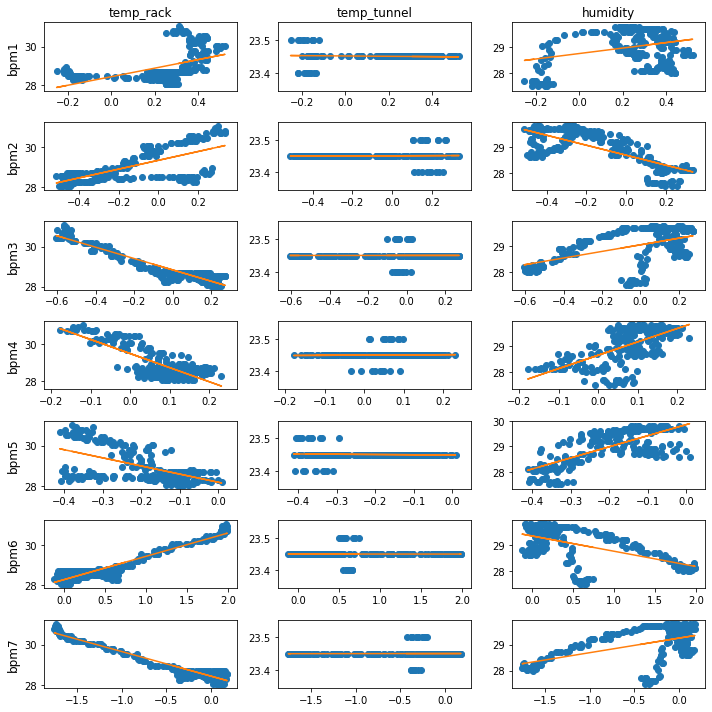

In [30]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_y[rows[i]],synch_y['temp_rack'])
    b, m = polyfit(synch_y[rows[i]], synch_y['temp_rack'], 1)
    axes[i][0].plot(synch_y[rows[i]], synch_y['temp_rack'], '.')
    axes[i][0].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')
    
    
    axes[i][1].scatter(synch_y[rows[i]],synch_y['temp_tunnel'])
    b, m = polyfit(synch_y[rows[i]], synch_y['temp_tunnel'], 1)
    axes[i][1].plot(synch_y[rows[i]], synch_y['temp_tunnel'], '.')
    axes[i][1].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')
    
    axes[i][2].scatter(synch_y[rows[i]],synch_y['humidity'])
    b, m = polyfit(synch_y[rows[i]], synch_y['humidity'], 1)
    axes[i][2].plot(synch_y[rows[i]], synch_y['humidity'], '.')
    axes[i][2].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')    
    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

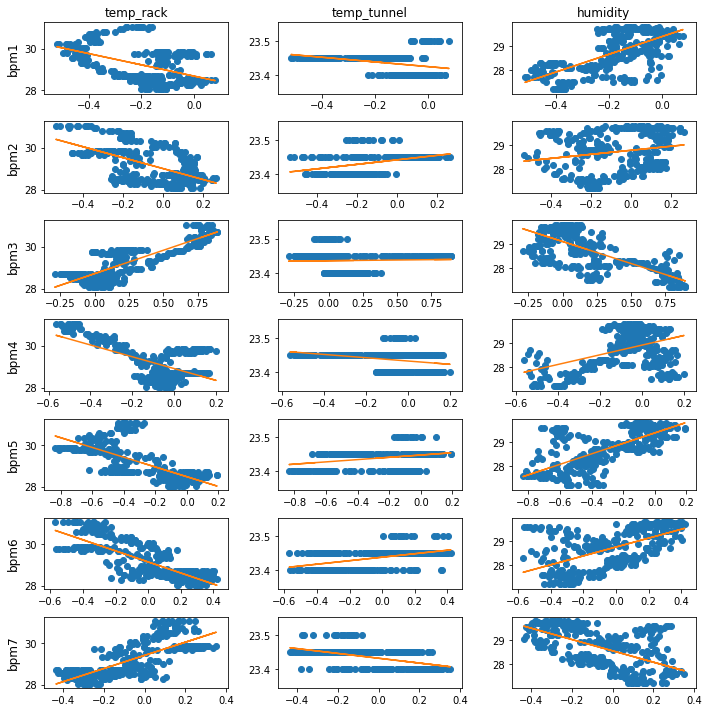

In [52]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_x[rows[i]],synch_x['temp_rack'])
    b, m = polyfit(synch_x[rows[i]], synch_x['temp_rack'], 1)
    axes[i][0].plot(synch_x[rows[i]], synch_x['temp_rack'], '.')
    axes[i][0].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')   
    
    axes[i][1].scatter(synch_x[rows[i]],synch_x['temp_tunnel'])
    b, m = polyfit(synch_x[rows[i]], synch_x['temp_tunnel'], 1)
    axes[i][1].plot(synch_x[rows[i]], synch_x['temp_tunnel'], '.')
    axes[i][1].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')    
    
    axes[i][2].scatter(synch_x[rows[i]],synch_x['humidity'])
    b, m = polyfit(synch_x[rows[i]], synch_x['humidity'], 1)
    axes[i][2].plot(synch_x[rows[i]], synch_x['humidity'], '.')
    axes[i][2].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

# Possible infuences to eliminate
- Plant causing MPS to drift
- Auto-gain control on BPM's off
- Insertion device movements
- Master frequency?

## Multiple regression on bpm7


Multiple regression on synchonised data, it appears that ...

In [31]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit regression model (using the natural log of one of the regressors)
results_y = smf.ols('bpm7 ~ temp_rack + temp_tunnel + humidity', data=synch_y).fit()
results_x = smf.ols('bpm7 ~ temp_rack + temp_tunnel + humidity', data=synch_x).fit()

# Inspect the results
print(results_y.summary())

                            OLS Regression Results                            
Dep. Variable:                   bpm7   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1990.
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          1.26e-173
Time:                        11:35:15   Log-Likelihood:                 164.72
No. Observations:                 253   AIC:                            -321.4
Df Residuals:                     249   BIC:                            -307.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -11.7884     13.365     -0.882      

In [32]:
print(results_x.summary())

                            OLS Regression Results                            
Dep. Variable:                   bpm7   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     287.4
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           1.95e-91
Time:                        11:35:22   Log-Likelihood:                 279.55
No. Observations:                 332   AIC:                            -551.1
Df Residuals:                     328   BIC:                            -535.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      67.9614      5.122     13.268      